TL;DR

Data: Top 100 movies (http://www.imdb.com/list/ls055592025/) with title, genre, and synopsis (IMDB and Wiki)
Goal: Put 100 movies into 5 clusters based on text mining their synopses

In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [ ]:
#dataframe
#df = pd.DataFrame(columns=['Title','Synopses', 'Genre', 'Language'])

In [ ]:

foreignMovies = pd.read_csv ('../../source/imdbMovies.csv', sep=';')



In [ ]:
print(foreignMovies.head())

In [79]:
titles=[]
for foreignMovie in foreignMovies['title']:
    #print(foreignMovie)
    titles.append(foreignMovie)

In [80]:
titles

['Feel Your Heartbeat: The Film (2022)',
 'The Witcher 3: Wild Hunt - Blood and Wine (2016)',
 'The Witcher 3: Wild Hunt - Hearts of Stone (2015)',
 'Brothers from Malta (2022)',
 'The Priceless Moments (2021)',
 'Dancing Through the Shadow (2021)',
 'Legend of the Galactic Heroes (1988)',
 'Carlo Goldoni: Venezia, Gran Teatro del Mondo (2007)',
 'Voynata na taralezhite (1979)',
 'Flames (2018)',
 'The Mystery of the Black Book (2019)',
 'A tanú (1969)',
 'The Big Picture (2007)',
 'Pretty Village, Pretty Flame (1996)',
 'Yakhanyeongung (2022)',
 'The Intouchables (2011)',
 'Attack on Titan: Chronicle (2020)',
 'Midnight Diner: Tokyo Stories (2016)',
 'Capernaum (2018)',
 'Flames: The Movie (1997)',
 'Ernest & Rebecca (2019)',
 'Heartbeat (2021)',
 'The Hunt (2012)',
 'Pather Panchali (1955)',
 'Incendies (2010)',
 'Supercops V/S Supervillains (2012)',
 'The Lemon Tree (1993)',
 'The Case Is Solved. I Know Everyone Who Tried to Kill Me (2020)',
 'Not Knowing Who You Are Is a Beautiful 

Read Genres information

In [81]:
genres=[]
for foreignMovie in foreignMovies['genre']:
    #print(foreignMovie)
    genres.append(foreignMovie)

In [ ]:
genres

Read in the desc from csv

In [82]:
synopses= []
for foreignMovie in foreignMovies['description']:
    #print(foreignMovie)
    synopses.append(foreignMovie)

In [ ]:
synopses

In [83]:
top100Movies = pd.read_csv ('../../source/top100desc.csv', sep=',')


In [85]:
top100Movies.head()

,Unnamed: 0,Title,Synopses,Genre
0,0,The Godfather,The aging patriarch of an organized crime dyna...,"Crime, Drama"
1,1,The Shawshank Redemption,Two imprisoned men bond over a number of years...,Drama
2,2,Schindler's List,"In German-occupied Poland during World War II,...","Biography, Drama, History"
3,3,Raging Bull,"The life of boxer Jake LaMotta, whose violence...","Biography, Drama, Sport"
4,4,Casablanca,A cynical expatriate American cafe owner strug...,"Drama, Romance, War"


In [86]:
for top100Movie in top100Movies['Title']:
    #print(foreignMovie)
    titles.append(top100Movie)
for top100Movie in top100Movies['Genre']:
    #print(foreignMovie)
    genres.append(top100Movie)
for top100Movie in top100Movies['Synopses']:
    #print(foreignMovie)
    synopses.append(top100Movie)

strips html formatting and converts to unicode

In [87]:
synopses_clean = []
for text in synopses:
    #print(text)
    text = BeautifulSoup(text, 'html.parser').getText()
    synopses_clean.append(text)
synopses = synopses_clean

/usr/local/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [88]:
synopses[0]

'Feel Your Heartbeat: The Film is the first documentary to tackle the deep roots of house music alongside its cultural history and evolution in Greece. From the underground party scene of 1989 to the economic crisis of Greece and t...'

In [89]:
print(str(len(titles)) + ' titles')
print(str(len(genres)) + ' genres')
print(str(len(synopses)) + ' synopses')

831 titles
831 genres
831 synopses


In [90]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
# the movies in the list are already ranked from 1 to 100
ranks = []
for i in range(1, len(titles)+1):
    ranks.append(i)

In [91]:
# load nltk's English stopwords as variable called 'stopwords'
# use nltk.download() to install the corpus first
# Stop Words are words which do not contain important significance to be used in Search Queries
stopwords = nltk.corpus.stopwords.words('english')

# load nltk's SnowballStemmer as variabled 'stemmer'
stemmer = SnowballStemmer("english")

In [ ]:
stopwordsNew = ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv']

In [93]:
stopwords.append("'s")
stopwords.append("one")
stopwords.append("two")
stopwords.append("'d")

In [94]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed
# Punkt Sentence Tokenizer, sent means sentence 
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [95]:

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized

In [96]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i) # for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) # extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [97]:
print(len(totalvocab_stemmed))
print(len(totalvocab_tokenized))

25342
25342


In [98]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
print(vocab_frame.head())

there are 25342 items in vocab_frame
               words
feel            feel
your            your
heartbeat  heartbeat
the              the
film            film


In [99]:
print(vocab_frame)

               words
feel            feel
your            your
heartbeat  heartbeat
the              the
film            film
...              ...
and              and
singer        singer
georg         george
m.                m.
cohan          cohan

[25342 rows x 1 columns]


Generate TF-IDF matrix (see http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)

min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.

ngram_range: this just means I'll look at unigrams, bigrams and trigrams

In [103]:
# Note that the result of this block takes a while to show
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(min_df=0.03,
                                  stop_words=stopwords,tokenizer=tokenize_and_stem)

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses

print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names_out()
terms


CPU times: user 466 ms, sys: 3.05 ms, total: 469 ms
Wall time: 468 ms
(831, 57)


array(['becom', 'boy', 'brother', 'child', 'citi', 'come', 'crime',
       'daughter', 'day', 'death', 'decid', 'dure', 'end', 'fall',
       'famili', 'father', 'film', 'find', 'follow', 'forc', 'friend',
       'get', 'girl', 'group', 'help', 'home', 'life', 'live', 'love',
       'make', 'man', 'marri', 'meet', 'men', 'mother', 'murder', 'must',
       'new', 'old', 'peopl', 'return', 'school', 'set', 'son', 'stori',
       'take', 'three', 'time', 'tri', 'war', 'way', 'wife', 'woman',
       'work', 'world', 'year', 'young'], dtype=object)

In [104]:
with open(r'terms.txt', 'w') as fp:
    for item in terms:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose k-means. K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima - how to decide that the algorithm converged???

In [157]:
from sklearn.cluster import KMeans
clusters=[]
num_clusters = 6
for i in range(6):
    km = KMeans(n_clusters=num_clusters)

    %time km.fit(tfidf_matrix)

    clusters = km.labels_.tolist()

CPU times: user 1.39 s, sys: 206 ms, total: 1.59 s
Wall time: 132 ms
CPU times: user 1.67 s, sys: 81.1 ms, total: 1.75 s
Wall time: 116 ms
CPU times: user 1.5 s, sys: 161 ms, total: 1.66 s
Wall time: 117 ms
CPU times: user 1.38 s, sys: 133 ms, total: 1.51 s
Wall time: 106 ms
CPU times: user 1.44 s, sys: 132 ms, total: 1.57 s
Wall time: 110 ms
CPU times: user 1.42 s, sys: 97.7 ms, total: 1.51 s
Wall time: 103 ms


I use joblib.dump to pickle the model, once it has converged and to reload the model/reassign the labels as the clusters.

In [158]:
import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()
# clusters show which cluster 
print(len(clusters))
print(clusters)

831
[4, 4, 4, 1, 1, 2, 4, 4, 4, 2, 4, 4, 2, 4, 4, 5, 4, 2, 4, 4, 4, 3, 1, 1, 1, 4, 2, 4, 4, 4, 4, 1, 4, 4, 4, 4, 3, 4, 5, 4, 2, 4, 4, 4, 4, 4, 5, 1, 0, 2, 2, 2, 0, 4, 2, 4, 4, 2, 4, 4, 0, 2, 3, 4, 4, 1, 4, 4, 4, 1, 0, 3, 2, 3, 4, 4, 5, 5, 4, 4, 0, 4, 4, 1, 3, 3, 1, 4, 2, 3, 4, 1, 4, 4, 2, 4, 4, 4, 1, 4, 4, 1, 1, 1, 0, 4, 4, 4, 5, 4, 5, 4, 4, 3, 4, 1, 1, 4, 3, 1, 4, 2, 4, 1, 4, 5, 4, 5, 1, 4, 1, 1, 5, 1, 0, 1, 1, 3, 4, 1, 5, 0, 4, 4, 4, 4, 4, 5, 3, 3, 4, 5, 5, 4, 1, 0, 2, 4, 5, 4, 3, 5, 1, 4, 1, 5, 4, 0, 4, 4, 4, 2, 4, 4, 3, 0, 5, 5, 4, 3, 4, 2, 4, 0, 4, 2, 4, 4, 4, 1, 4, 4, 1, 1, 1, 4, 4, 0, 4, 1, 4, 5, 2, 5, 1, 4, 4, 1, 5, 1, 0, 0, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 0, 0, 4, 0, 5, 5, 4, 4, 4, 4, 4, 2, 2, 4, 4, 0, 4, 5, 0, 4, 2, 4, 1, 2, 4, 4, 5, 4, 1, 3, 5, 4, 4, 4, 1, 1, 5, 5, 4, 4, 4, 4, 4, 1, 4, 2, 4, 4, 4, 2, 4, 2, 4, 1, 3, 4, 1, 3, 4, 4, 4, 4, 4, 4, 1, 2, 0, 5, 4, 4, 4, 4, 5, 1, 1, 4, 1, 1, 4, 3, 4, 3, 4, 4, 4, 2, 4, 1, 4, 4, 2, 4, 4, 5, 3, 1, 4, 1, 2, 2, 3, 2, 1, 4, 4, 2,

Here, I create a dictionary of titles, ranks, the synopsis, the cluster assignment, and the genre [rank and genre were scraped from IMDB].
I convert this dictionary to a Pandas DataFrame for easy access. I'm a huge fan of Pandas and recommend taking a look at some of its awesome functionality which I'll use below, but not describe in a ton of detail.

In [159]:
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

#print(films)

frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

print(frame) # here the ranking is still 0 to 99

frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

    rank                                              title  cluster  \
4      1               Feel Your Heartbeat: The Film (2022)        4   
4      2   The Witcher 3: Wild Hunt - Blood and Wine (2016)        4   
4      3  The Witcher 3: Wild Hunt - Hearts of Stone (2015)        4   
1      4                         Brothers from Malta (2022)        1   
1      5                       The Priceless Moments (2021)        1   
..   ...                                                ...      ...   
4    827                                        Rear Window        4   
0    828                                      The Third Man        0   
0    829                              Rebel Without a Cause        0   
4    830                                 North by Northwest        4   
1    831                                Yankee Doodle Dandy        1   

                           genre  
4             Documentary, Music  
4       Action, Adventure, Drama  
4       Action, Adventure, Dra

4    453
1    101
5     74
3     71
0     71
2     61
Name: cluster, dtype: int64

In [160]:
grouped = frame['rank'].groupby(frame['cluster']) # groupby cluster for aggregation purposes

grouped.mean() # average rank (1 to 100) per cluster

cluster
0    481.478873
1    359.079208
2    343.098361
3    430.028169
4    434.399558
5    364.864865
Name: rank, dtype: float64

Note that clusters 4 and 0 have the lowest rank, which indicates that they, on average, contain films that were ranked as "better" on the top 100 list.
Here is some fancy indexing and sorting on each cluster to identify which are the top n (I chose n=6) words that are nearest to the cluster centroid. This gives a good sense of the main topic of the cluster.

In [161]:
from __future__ import print_function

print("Top terms per cluster:")

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace


Top terms per cluster:
Cluster 0 words: b'finds', b'friend', b'new', b'man', b'lives', b'home', b'death', b'help', b'trying', b'years',

Cluster 0 titles: The Long Road Home (2012), Mommy (2014), Three Colors: Blue (1993), Tokyo Godfathers (2003), Breathless (2018), The Fairies (2005), Pickpocket (1997), Biyudo si daddy, biyuda si mommy (1997), Infernal Affairs II (2003), When Heroes Fly (2018), The Age of Assassins (1967), The Emperor and the Assassin (1998), Timbuktu (2014), L'enfant perdu (1997), Nero a metà (2018), Nafas-borideh (1978), Chicken with Plums (2011), Alphaville (1965), In the Shadows (2017), Mon amour (2020), Timbuktu (2004), Code Geass: Akito the Exiled 4 - From the Memories of Hatred (2015), Exiled (2016), Amour fou (2020), Punttikomedia (2022), Love is in the Air (2013), Song of the Assassins (2022), Tokyo Noir (2004), The Witnesses (2021), My Best Friend Anne Frank (2021), Heartbeats (2019), Magic Hour: Tom Alone (1989), Dreamchild (2020), A Priceless Love (2022), 

Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus (each synopsis among the synopses). cosine similarity 1 means the same document, 0 means totally different ones. dist is defined as 1 - the cosine similarity of each document.  Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.
Note that with dist it is possible to evaluate the similarity of any two or more synopses.

In [162]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_distance = 1 - cosine_similarity(tfidf_matrix)
print(type(similarity_distance))
print(similarity_distance.shape)

<class 'numpy.ndarray'>
(831, 831)


Multidimensional scaling
Here is some code to convert the dist matrix into a 2-dimensional array using multidimensional scaling. I won't pretend I know a ton about MDS, but it was useful for this purpose. Another option would be to use principal component analysis.

In [144]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(similarity_distance)  # shape (n_components, n_samples)

print(pos.shape)
print(pos)

xs, ys = pos[:, 0], pos[:, 1]
print(type(xs))
xs

CPU times: user 1min 11s, sys: 41.3 s, total: 1min 52s
Wall time: 14.5 s
(831, 2)
[[-0.75227304 -0.01651796]
 [-0.53683104 -0.38965851]
 [ 0.12031166  0.73628366]
 ...
 [-0.24544497  0.20826385]
 [ 0.03312028 -0.27813232]
 [ 0.54194031 -0.3010976 ]]
<class 'numpy.ndarray'>


array([-0.75227304, -0.53683104,  0.12031166,  0.73357003,  0.3598704 ,
       -0.00428286, -0.47749438,  0.25026145, -0.64019372, -0.40109954,
       -0.66778941, -0.76055024, -0.50450412, -0.10074346,  0.6782382 ,
        0.10318744, -0.53690922, -0.60308221,  0.07258653,  0.21999655,
       -0.03408451,  0.15198472,  0.12801614,  0.60806875,  0.73511506,
       -0.39241095, -0.61926422, -0.53869728, -0.5723843 ,  0.46978737,
       -0.69426902,  0.40097903,  0.1906842 , -0.47976488,  0.19068757,
        0.16943288,  0.00507215, -0.64245744, -0.08528022, -0.48013425,
       -0.43376019, -0.03391576,  0.53637033,  0.39880846,  0.51917257,
        0.33483373, -0.15484617,  0.64774469, -0.27238408, -0.51625817,
       -0.6554268 , -0.45641124,  0.07546156, -0.0392963 , -0.46660455,
       -0.70829498, -0.79741204, -0.51759037,  0.39880846,  0.36248926,
       -0.18368416, -0.45313638,  0.40049818, -0.03720342, -0.26964601,
        0.68448345,  0.78869414,  0.26446127, -0.75227304,  0.09

Visualizing document clusters
In this section, I demonstrate how you can visualize the document clustering output using matplotlib and mpld3 (a matplotlib wrapper for D3.js).
First I define some dictionaries for going from cluster number to color and to cluster name. I based the cluster names off the words that were closest to each cluster centroid.

In [165]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5:'#CF3476', 6:'#3F888F', 7:'#6C7156', 8:'#4C514A', 9: '#59351F' }

#set up cluster names using a dict
cluster_names = {0: 'finds, friend, new, man, lives, home', 
                 1: "family, life, work, lives", 
                 2: "story, people, love, lives", 
                 3: "love, falls, life, woman, young", 
                 4: "film, world, friend, war, murder, death",
                 5: "young, woman, man, meets, become, father, child",
               }


Next, I plot the labeled observations (films, film titles) colored by cluster using matplotlib. I won't get into too much detail about the matplotlib plot, but I tried to provide some helpful commenting.

          x         y  label  \
1 -0.536831 -0.389659      4   
2  0.120312  0.736284      4   
3  0.733570  0.034988      1   
4  0.359870 -0.089430      1   
5 -0.004283 -0.276286      2   
6 -0.477494 -0.586784      4   
7  0.250261  0.776607      4   
8 -0.640194  0.417510      4   
9 -0.401100 -0.232565      2   

                                               title  
1   The Witcher 3: Wild Hunt - Blood and Wine (2016)  
2  The Witcher 3: Wild Hunt - Hearts of Stone (2015)  
3                         Brothers from Malta (2022)  
4                       The Priceless Moments (2021)  
5                  Dancing Through the Shadow (2021)  
6               Legend of the Galactic Heroes (1988)  
7  Carlo Goldoni: Venezia, Gran Teatro del Mondo ...  
8                      Voynata na taralezhite (1979)  
9                                      Flames (2018)  
{0: [48, 52, 60, 70, 80, 104, 134, 141, 155, 167, 175, 183, 197, 210, 211, 226, 227, 229, 241, 244, 292, 350, 357, 390, 398, 399,

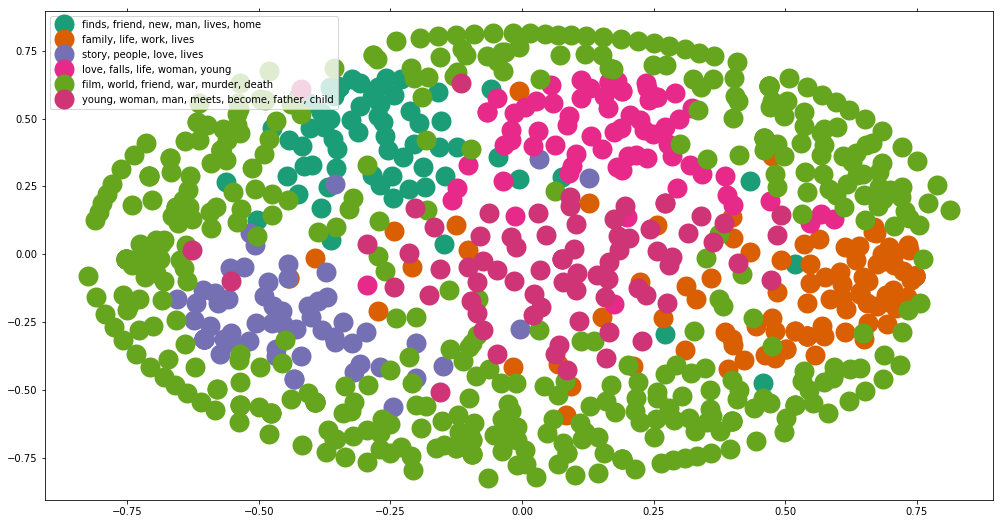

In [166]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

df.to_csv('moovies3_less.csv')

print(df[1:10])
# group by cluster
# this generate {name:group(which is a dataframe)}
groups = df.groupby('label')
print(groups.groups)

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
# ms: marker size
for name, group in groups:
    print("*******")
    print("group name " + str(name))
    print(group)
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], '', size=10)  

    
    
#plt.show() #show the plot

#uncomment the below to save the plot if need be

plt.savefig('clusters_small_noaxes3_less.png', dpi=200)

Use plotly to generate interactive chart. I have to downgrade matplotlib to 1.3.1 for this chart to work with plotly. see https://github.com/harrywang/plotly/blob/master/README.md for how to setup plotly. After running the following, a browser will open to show the plotly chart.

In [147]:
 #import chart_studio.plotly as py
 #plot_url = py.plot_mpl(fig)